In [54]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Standard library imports.
import os
from datetime import timedelta, datetime
import pprint
import pickle
import json
from typing import List, Dict

# Related third party imports.
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# Local application/library specific imports.
from cerebralcortex.cerebralcortex import CerebralCortex
from cerebralcortex.core.datatypes.datastream import DataPoint
import utils
import validation


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
# Set important paths
config_path = '../config/'
data_path = '../data/'

# Load all user IDs
with open(config_path+'users.json', 'r') as f:
    USR_IDS = json.load(f)

# Load all users' work days
with open(data_path+'usr_work_days.pkl', 'rb') as f:
    usr_work_days = pickle.load(f)

(array([ 4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 31.]),
 array([0.025 , 0.1225, 0.22  , 0.3175, 0.415 , 0.5125, 0.61  , 0.7075,
        0.805 , 0.9025, 1.    ]),
 <a list of 10 Patch objects>)

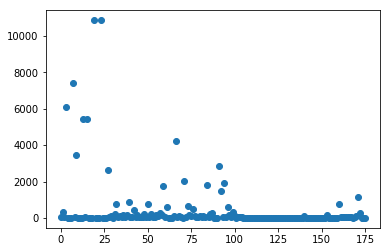

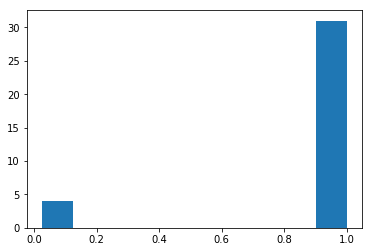

In [39]:
step_cnt_fn = '/home/mperf/sandeep/Codes/data/03996723-2411-4167-b14b-eb11dfc33124/step_cnt20180102.npz'
accel_fn = '/home/mperf/sandeep/Codes/data/03996723-2411-4167-b14b-eb11dfc33124/accel20180102.npz'
gyro_fn = '/home/mperf/sandeep/Codes/data/03996723-2411-4167-b14b-eb11dfc33124/gyro20180102.npz'
act_type_fn = '/home/mperf/sandeep/Codes/data/03996723-2411-4167-b14b-eb11dfc33124/act_type20180102.npz'
arrays = np.load(fn)
np.set_printoptions(suppress=True)
accel = arrays['arr_0']


plt.figure()
plt.plot(np.ediff1d(accel[:, 0]), 'o')
plt.figure()
plt.hist(np.ediff1d(accel[:, 0]), range=(0.025, 1))
# print(file['arr_0'][0][0] -test['arr_0'][1][0])

In [87]:
def resample(x, start_t, end_t, freq):
    'Resample x with freq from start_t to end_t'
    
    f_new = interp1d(x[:, 0], x[:, 2:], kind='zero', axis=0)
    # print((min(end_ts) - max(start_ts))/3600)
    ts_new = np.arange(start_t, end_t, 1.0/freq)
    x_new = np.hstack((ts_new.reshape((-1, 1)), f_new(ts_new)))
    return x_new


INTERP_FREQ = 20.0 # 20.0 HZ

for usr_id in usr_work_days:
    usr_path = data_path+usr_id+'/'
    for day in usr_work_days[usr_id]:

        accel = np.load(usr_path+'accel'+day+'.npz')['arr_0']
        act_type = np.load(usr_path+'act_type'+day+'.npz')['arr_0']
        gyro = np.load(usr_path+'gyro'+day+'.npz')['arr_0']
        step_cnt = np.load(usr_path+'step_cnt'+day+'.npz')['arr_0']
        start_t = max([accel[0][0], act_type[0][0], 
                       gyro[0][0], step_cnt[0][0]])
        end_t = min([accel[-1][0], act_type[-1][0], 
                     gyro[-1][0], step_cnt[-1][0]])
        
        accel = resample(accel, start_t, end_t, INTERP_FREQ)
        act_type = resample(act_type, start_t, end_t, INTERP_FREQ)
        gyro = resample(gyro, start_t, end_t, INTERP_FREQ)
        step_cnt  = resample(step_cnt, start_t, end_t, INTERP_FREQ)
        
        np.savez(usr_path+'data'+day+'.npz',
                 accel=accel,
                 act_type=act_type,
                 gyro=gyro,
                 step_cnt=step_cnt)
#     try:
#         x = np.load(usr_path+'data'+day+'.npz')
#         print(x.files)
#     except FileNotFoundError:
#         continue

['accel', 'act_type', 'gyro', 'step_cnt']
['accel', 'act_type', 'gyro', 'step_cnt']
['accel', 'act_type', 'gyro', 'step_cnt']
['accel', 'act_type', 'gyro', 'step_cnt']
['accel', 'act_type', 'gyro', 'step_cnt']
['accel', 'act_type', 'gyro', 'step_cnt']
['accel', 'act_type', 'gyro', 'step_cnt']
